In [1]:
from Bagging import create_models, create_bags, evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import random
from BaggingSA import BaggingSA

seed = 41
np.random.seed(seed)
random.seed(seed)

In [2]:
from typing import Tuple
import sklearn


def get_dataset(dataset_name: str) -> Tuple[np.ndarray, np.ndarray]:
    if dataset_name == 'digits':
        data = sklearn.datasets.load_digits()
        X = data.data
        y = data.target
        
    elif dataset_name == 'wine':
        data = sklearn.datasets.load_wine()
        X = data.data
        y = data.target
    
    elif dataset_name == 'breast_cancer':
        data = sklearn.datasets.load_breast_cancer()
        X = data.data
        y = data.target
        
    elif dataset_name == 'pima':
        data = pd.read_csv("./../datasets/pima.csv")
        X = data.iloc[:, :-1].values
        y = data.iloc[:, -1].values
    
    else:
        raise ValueError("Unsupported dataset")
    return X, y


X,y = get_dataset('digits')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [3]:
def evaluate_bagging_sa():
    bagging_sa = BaggingSA(X=X_train, y=y_train,
                                T0=2.0, alpha=0.995, cooling_method= 'geometric', max_iterations=2000, n_trees=10,
                                fitness_accuracy_diversity_ratio=0.75,
                                feature_mutation_chance=0.2, test_split_amount=1)
    models, fitness = bagging_sa.run(X_for_test=X_test, y_for_test=y_test, monitor_fun=fun_monitor, get_fitness=True)
    accuracy = evaluate(X_test, y_test, models=models)
    return accuracy, models, fitness


fits = []
accs = []
run_through_res = []
def fun_monitor(iteration, T, best_fitness, fitness, new_fitness, accuracy):
    if accuracy is None:
        accuracy = 0.0
    
    print(f"I: {iteration}, T: {T:.3f}, Best fitness: {best_fitness:.3f}, Fitness: {fitness:.3f}, New fitness: {new_fitness:.3f}, Accuracy: {accuracy:.3f}")
    fits.append(new_fitness)
    accs.append(accuracy)
    run_through_res.append([iteration, T, best_fitness, fitness, new_fitness, accuracy])
    global diff_sum

acc_sa, models, fitness_sa = evaluate_bagging_sa()
df = pd.DataFrame(run_through_res, columns=['Iteration', 'T', 'BestFitness', 'Fitness', 'NewFitness', 'Accuracy'])

df.to_csv('./../res/bagging_sa_detail_geometric.csv', index=False)


I: 1, T: 2.000, Best fitness: 0.782, Fitness: 0.782, New fitness: 0.780, Accuracy: 0.833
I: 2, T: 1.990, Best fitness: 0.782, Fitness: 0.780, New fitness: 0.793, Accuracy: 0.803
I: 3, T: 1.980, Best fitness: 0.793, Fitness: 0.793, New fitness: 0.806, Accuracy: 0.794
I: 4, T: 1.970, Best fitness: 0.806, Fitness: 0.806, New fitness: 0.793, Accuracy: 0.817
I: 5, T: 1.960, Best fitness: 0.806, Fitness: 0.793, New fitness: 0.802, Accuracy: 0.803
I: 6, T: 1.950, Best fitness: 0.806, Fitness: 0.802, New fitness: 0.808, Accuracy: 0.817
I: 7, T: 1.941, Best fitness: 0.808, Fitness: 0.808, New fitness: 0.805, Accuracy: 0.831
I: 8, T: 1.931, Best fitness: 0.808, Fitness: 0.805, New fitness: 0.829, Accuracy: 0.847
I: 9, T: 1.921, Best fitness: 0.829, Fitness: 0.829, New fitness: 0.841, Accuracy: 0.856
I: 10, T: 1.912, Best fitness: 0.841, Fitness: 0.841, New fitness: 0.853, Accuracy: 0.844
I: 11, T: 1.902, Best fitness: 0.853, Fitness: 0.853, New fitness: 0.814, Accuracy: 0.839
I: 12, T: 1.893, Be

In [4]:
print("++==============================")
print(f"|| Fitness:  {fitness_sa:.3f}")
print(f"|| Accuracy: {acc_sa:.3f}")
print("++==============================")


++==============================
|| Fitness:  0.933
|| Accuracy: 0.847
++==============================


In [5]:
from Bagging import predict

for i, model in enumerate(models):
    y_pred = predict(X_test, [model])
    acc = accuracy_score(y_test, y_pred)
    print(f"Model [{i}] accuracy: {acc:.3f}")


Model [0] accuracy: 0.500
Model [1] accuracy: 0.631
Model [2] accuracy: 0.578
Model [3] accuracy: 0.636
Model [4] accuracy: 0.478
Model [5] accuracy: 0.500
Model [6] accuracy: 0.575
Model [7] accuracy: 0.469
Model [8] accuracy: 0.486
Model [9] accuracy: 0.578


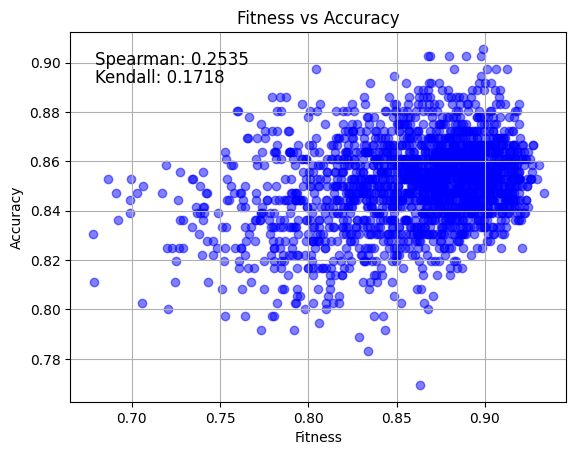

Spearman correlation: 0.2535 (p=1.0844e-30)
Kendall's Tau: 0.1718 (p=2.1417e-29)
Pearson correlation: 0.2960 (p=9.9077e-42)


In [6]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau, pearsonr


X1 = fits
X2 = accs

spearman_corr, spearman_p = spearmanr(X1, X2)
kendall_corr, kendall_p = kendalltau(X1, X2)
pearson_corr, pearson_p = pearsonr(X1, X2)

plt.scatter(X1, X2, c='blue', alpha=0.5)

plt.text(0.05, 0.95, f'Spearman: {spearman_corr:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'Kendall: {kendall_corr:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.xlabel('Fitness')
plt.ylabel('Accuracy')
plt.title('Fitness vs Accuracy')
plt.grid(True)
plt.show()




print(f"Spearman correlation: {spearman_corr:.4f} (p={spearman_p:.4e})")
print(f"Kendall's Tau: {kendall_corr:.4f} (p={kendall_p:.4e})")
print(f"Pearson correlation: {pearson_corr:.4f} (p={pearson_p:.4e})")


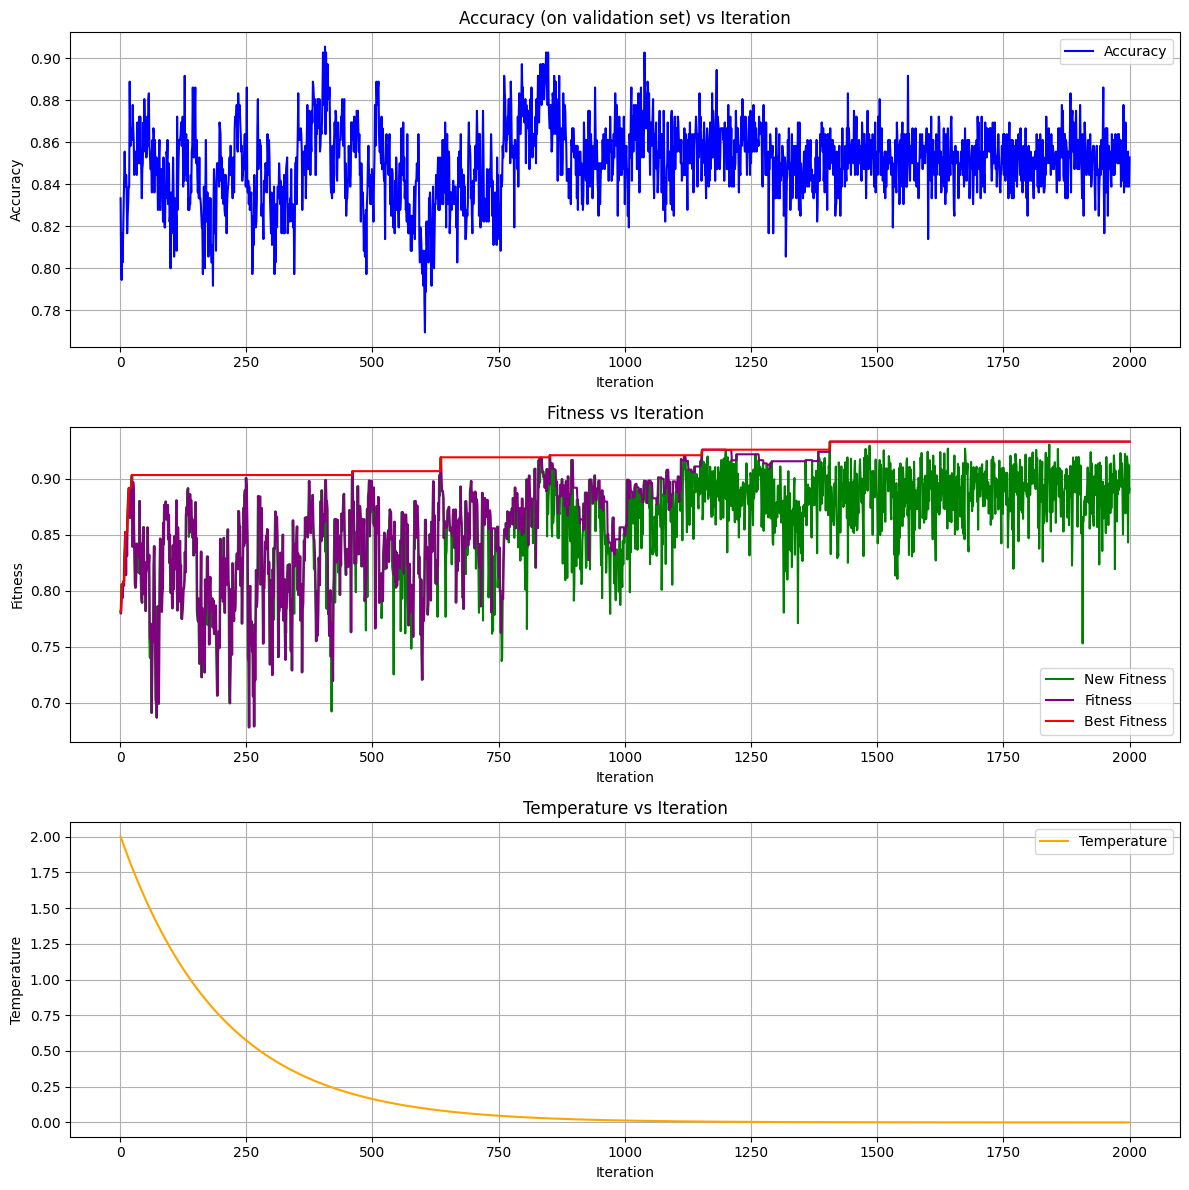

In [7]:
X = df['Iteration']

Y1 = df['Accuracy']

Y2 = df['NewFitness']
Y2_2 = df['BestFitness']
Y2_3 = df['Fitness']

Y3 = df['T']

fig, axs = plt.subplots(3, 1, figsize=(12, 12))
axs[0].plot(X, Y1, label="Accuracy", color="blue")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Accuracy (on validation set) vs Iteration")
axs[0].grid()   
axs[0].legend()

axs[1].plot(X, Y2, label="New Fitness", color="green")
axs[1].plot(X, Y2_3, label="Fitness", color="purple")
axs[1].plot(X, Y2_2, label="Best Fitness", color="red")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Fitness")
axs[1].set_title("Fitness vs Iteration")
axs[1].grid()
axs[1].legend()


axs[2].plot(X, Y3, label="Temperature", color="orange")
axs[2].set_xlabel("Iteration")
axs[2].set_ylabel("Temperature")
axs[2].set_title("Temperature vs Iteration")
axs[2].grid()
axs[2].legend()

plt.tight_layout()
# plt.savefig('./../res/bagging_sa_detail_geometric.png')

plt.show()